<a href="https://colab.research.google.com/github/giomagg/Digital_Inequalities_SPRING_2023/blob/main/Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialisation

In [ ]:
! pip install minet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd

os.chdir("/content/drive/MyDrive")

#Data collection

In [ ]:
import minet

In [ ]:
! minet tw scrape tweets "frances haugen lang:en until:2021-11-30 since:2021-10-01"  -o "/content/drive/MyDrive/haugen1.csv" # different iterations were used and then joined in one df due to rate limits

In [ ]:
! minet tw scrape tweets "#mudge lang:en until:2022-10-15 since:2022-08-15"  -o "/content/drive/MyDrive/zatko1.csv"  # different iterations were used and then joined in one df due to rate limits

#Data Analyses

###Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pandas as pd
import numpy as np

os.chdir("/content/drive/MyDrive") 

In [ ]:
df_haugen = pd.concat([pd.read_csv("haugen1.csv"), pd.read_csv("haugen.csv")])
df_zatko = pd.concat([pd.read_csv("zatko.csv"), pd.read_csv("zatko1.csv")])

## Topic Modelling – BERTopic

###Install libraries

In [ ]:
!pip install bertopic

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

###Text Prep

In [ ]:
import re
import pandas as pd

#CLEAN HAUGEN DATASET
df_haugen.text = df_haugen.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df_haugen.text = df_haugen.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df_haugen.text = df_haugen.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df_haugen = df_haugen.loc[(df_haugen.text != ""), :]

df_zatko.text = df_zatko.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
df_zatko.text = df_zatko.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df_zatko.text = df_zatko.apply(lambda row: " ".join(re.sub("[^a-zA-ZüöäÜÖÄ]+", " ", row.text).split()), 1)
df_zatko = df_zatko.loc[(df_zatko.text != ""), :]

###Topic Modelling for Haugen

In [ ]:
documents = list(df_haugen['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language="multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
model_haugen.visualize_barchart(top_n_topics=20, n_words=10)

NB: Andymstone is Meta's communication director

In [ ]:
model_haugen.get_representative_docs() # used to analyse individual topics

###Topic Modelling for Zatko


In [ ]:
documents = list(df_zatko['text'].str.lower())

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")
document_vectors = model.encode(documents, show_progress_bar=True)

In [ ]:
vectorizer = CountVectorizer(stop_words=stopwords)
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=2, metric='euclidean', cluster_selection_method='eom')

In [ ]:
topic_model = BERTopic(
    language="multilingual",
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    verbose=True
).fit(documents, document_vectors)

In [ ]:
model_zatko.visualize_barchart(top_n_topics=20, n_words=10)

In [ ]:
model_zatko.get_representative_docs()

### Further Analyses

In [ ]:
similar_topics, similarity = model_haugen.find_topics("woman", top_n=10)
model_haugen.get_topic(similar_topics[0])

[('brave', 0.1782322453917799),
 ('women', 0.11712092551950368),
 ('men', 0.06975386978169863),
 ('woman', 0.062280826469225684),
 ('chrissyfarr', 0.04478584175717931),
 ('ruthsentus', 0.04478584175717931),
 ('1445791214704336908', 0.04478584175717931),
 ('braver', 0.04478584175717931),
 ('ambjohnbolton', 0.04478584175717931),
 ('womenwholead', 0.04478584175717931)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=1000) # Look 1000 topics for Frances Haugen to investigate individual words

## Sentiment

In [ ]:
import pandas as pd
import numpy as np

df_haugen["polarity"] = np.nan
df_zatko["polarity"] = np.nan

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install spacytextblob

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

####Polarity for haugen

In [ ]:
#calculates polarity for each column
for i in range(len(df_haugen)):
  text = str(df_haugen.iloc[i].text)
  doc = nlp(text)
  df_haugen_polarity.polarity[i] = doc._.blob.polarity

In [ ]:
print("The average polarity for Haugen is:", sum(df_haugen["polarity"])/len(df_haugen["polarity"]))

The average polarity for Haugen is: 0.04238240000609557


####Polarity for Zatko

In [ ]:
for i in range(len(df_zatko)):
  text = str(df_zatko.iloc[i].text)
  doc = nlp(text)
  df_zatko.polarity[i] = doc._.blob.polarity

In [ ]:
print("The average polarity for Zatko is:", sum(df_zatko["polarity"])/len(df_zatko["polarity"]))

The average polarity for Zatko is: 0.0025715354739975272


####Plot Polarity over Time

#####Zatko

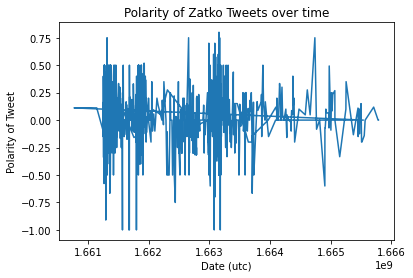

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

fig, ax = plt.subplots() 
ax.set_xlabel('Date (utc)')
ax.set_ylabel('Polarity of Tweet')
ax.set_title("Polarity of Zatko Tweets over time")

ax.plot(df_zatko["timestamp_utc"], df_zatko["polarity"])

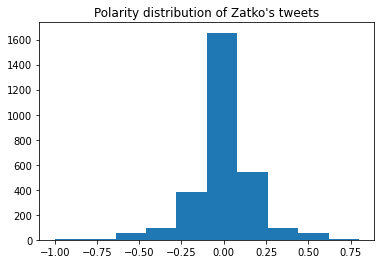

In [ ]:
plt.hist(df_zatko["polarity"])
plt.title("Polarity distribution of Zatko's tweets")
plt.show() 

#####Haugen

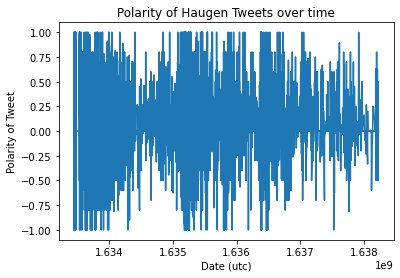

In [ ]:
fig, ax = plt.subplots() 
ax.set_xlabel('Date (utc)')
ax.set_ylabel('Polarity of Tweet')
ax.set_title("Polarity of Haugen Tweets over time")

ax.plot(df_haugen["timestamp_utc"], df_haugen["polarity"])

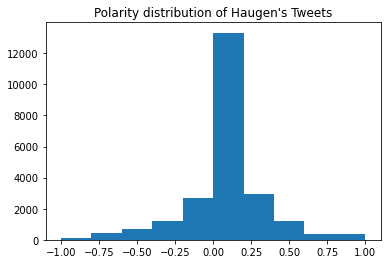

In [ ]:
plt.hist(df_haugen["polarity"])
plt.title("Polarity distribution of Haugen's Tweets")
plt.show() 

#### Plot RT vs. Polarity

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

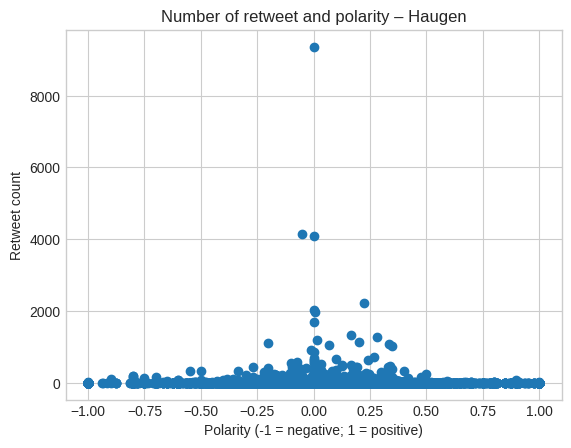

In [ ]:
plt.scatter(df_haugen["polarity"], df_haugen["retweet_count"], marker='o')
plt.title("Number of retweet and polarity – Haugen")
plt.xlabel("Polarity (-1 = negative; 1 = positive)")
plt.ylabel("Retweet count")
plt.show()

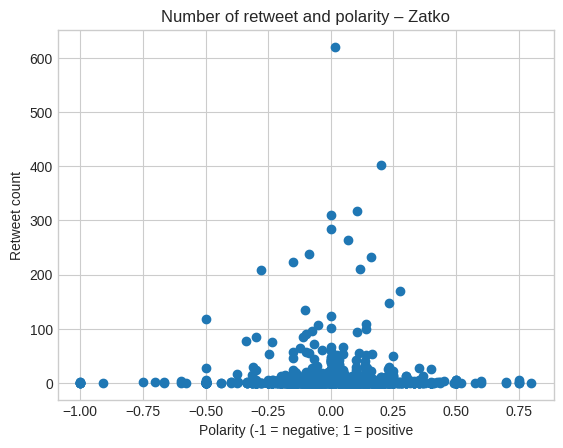

In [ ]:
plt.scatter(df_zatko["polarity"], df_zatko["retweet_count"], marker='o')
plt.title("Number of retweet and polarity – Zatko")
plt.xlabel("Polarity (-1 = negative; 1 = positive")
plt.ylabel("Retweet count")
plt.show()

In [ ]:
np.std(df_haugen["polarity"]) #standard deviation

0.25038837378884105

In [ ]:
np.std(df_zatko["polarity"]) #standard deviation

0.17694501188309317

##Word counts

####Dictionary harrassement

In [ ]:
harrassement_dic = ["amateur",
"AnalAnnie",
"Angie",
"Aroused",
"assblaster",
"ass cowboy",
"ass jacker",
"AssMan",
"assranger",
"ass whore",
"Ass-assinate",
"ass-jabber",
"ass-pirate",
"assbandit",
"assbanger",
"assfuck",
"assfucker",
"asshopper",
"assklown",
"asslick",
"asslicker",
"asspacker",
"asspuppy",
"asssucker",
"backdoor",
"backdoor man",
"Bad Fuck",
"Ball licker",
"Balls",
"banging",
"bastard",
"bastard",
"beastiality",
"beaver",
"big butt",
"bitch ass",
"bitcher",
"bitchtits",
"bite me",
"Blowjob",
"blowjob",
"BOMD",
"boobies",
"boobs",
"BOONGA",
"brea5t",
"Breast Job",
"Breast Man",
"brothel",
"brotherfucker",
"buggery",
"bulldike",
"bulldyke",
"bumblefuck",
"bunga",
"Bunghole",
"ButchDyke",
"butt",
"butt fucker",
"butt pirate",
"buttbang",
"Buttfuck",
"buttfucka",
"butthead",
"buttpirate",
"byatch",
"carpet muncher",
"cherry popper",
"chin",
"Chode",
"Clam digger",
"Clit",
"clitfuck",
"cock",
"cock block",
"cock cowboy",
"cock fight",
"cock jockey",
"Cock knob",
"Cock Licker",
"Cock Smoke",
"cock suck",
"cock tease",
"cockblocker",
"Cockhead",
"cockmaster",
"cockmongler",
"cockmuncher",
"Cocknugget",
"Cockqueen",
"cockrider",
"cocksman",
"cocksmith",
"cocksmoker",
"cocksniffer",
"cocksucked",
"Cocksucker",
"Cocksucking",
"coochie",
"coochy",
"coondog",
"cornhole",
"crotchrot",
"cum",
"cum bubble",
"cum guzzler",
"Cum jockey",
"cum tart",
"cumdumpster",
"cummer",
"cumming",
"Cumqueen",
"cumshot",
"cunilingus",
"cunnilingus",
"cunt",
"cunt rag",
"Cuntass",
"cuntfuck",
"cuntfucker",
"cunthole",
"cuntlick",
"cuntlicker",
"cuntlicking",
"deepthroat",
"destroy",
"dick beaters",
"Dick for brains",
"Dick Licker",
"dick weasel",
"dick wod",
"Dickbag",
"Dickfuck",
"dickfucker",
"dicklick",
"dickman",
"dickmonger",
"dickslap",
"dicksucker",
"dicksucking",
"dicktickler",
"dipstick",
" Dix ",
"doggystyle",
"dyke",
"eat me",
"eat pussy",
"Ejaculate",
"ejaculating",
"enema",
"erection",
"escort",
"Fagfucker",
"faggot",
"fagot",
"fanny fucker",
"fastfuck",
"fear",
"felatio",
"Felch",
"felcher",
"felching",
"fellatio",
"Feltcher",
"feltching",
"finger fuck",
"finger fucker",
"fingerfuckers",
"fingerfucking",
"fist fuck",
"fist fucked",
"fistfucker",
"fistfucking",
"fisting",
"Flange",
"foot fuck",
"footfucker",
"Foursome",
"free fuck",
"fu ",
"fuck ",
"fucka ",
"fuckable",
"fuckass",
"fuckbag",
"fuckboy",
"fuckbrain",
"fuckbuddy",
"fucked",
"fucker",
"fuckers",
"fuckersucker",
"fuckface",
"fuckfest",
"fuckfreak",
"fuckfriend",
"fuckhead",
"fuckher",
"fuckina",
"fucking",
"fuckingbitch",
"fuckit",
"fuckknob",
"fuckme",
"fuckmehard",
"fuckmonkey",
"fuckpig",
"fucktard",
"fuckup",
"fuckwhore",
"fuckyou",
"fudge packer",
"Fugly",
"Funfuck",
"gangbang",
"gangbanger",
"gayass",
"gaybob",
"gaydo",
"gayfuck",
"gayfuckist",
"gaylord",
"gaytard",
"gaywad",
"genitals",
"give head",
"Glazed donut",
"goddamn",
"goldenshower",
"gooch",
"handjob",
"harder",
"harem",
"headfuck",
"Henig",
"heterosexual",
"homo",
"homosexual",
"hose job",
"hotpussy",
"humping",
"hussy",
"hymen",
"incest",
"insest",
"intheass",
"inthebuff",
"jiggabo",
"jism",
"jiz ",
"jizim",
"jizjuice",
"jizm",
"jizzim",
"jizzum",
"jugs",
"kaffer",
"kaffir",
"kaffre",
"kanake",
"kinky",
"kissass",
"kondum",
"kooch",
"kootch",
"kum",
"kunilingus",
"kunnilingus",
"kunt",
"lam diver",
"lapdance",
"lesbain",
"lesbayn",
"lesbin",
"lez",
"lezbe",
"lezbefriends",
"lezbo",
"lezz",
"lezzie",
"lezzo",
"libido",
"limpdick",
"livesex",
"loadedgun",
"lolita",
"lovebone",
"lovejuice",
"lovemuscle",
"lubejob",
"mastabate",
"mastabater",
"masterbate",
"masterblaster",
"mastrabator",
"masturbate",
"masturbating",
"milf",
"minge",
"molest",
"molestation",
"molester",
"molestor",
"moneyshot",
"mothafucka",
"mothafuckin",
"motherfucker",
"motherfucking",
"muffdive",
"muffindiver",
"mufflikcer",
"nipple",
"nittit",
"nook",
"nookey",
"nookie",
"nooner",
"nude",
"nutsack",
"orgasim",
"orgasm",
"panooch",
"pearlnecklace",
"pecker",
"peehole",
"peni5",
"penile",
"penis",
"penisbanger",
"penises",
"penisfucker",
"penispuffer",
"phonesex",
"pindick",
"pissflaps",
"playboy",
"playgirl",
"polesmoker",
"poon",
"poonani",
"poontang",
"porn",
"pornflick",
"pornking",
"porno",
"pornography",
"pornprincess",
"prostitute",
"pu55i",
"pu55y",
"pube",
"pud",
"pudboy",
"pudd",
"puddboy",
"puntang",
"puss",
"pussie",
"pussies",
"pussycat",
"pussyeater",
"pussyfucker",
"pussylicker",
"pussylicking",
"pussylips",
"pussylover",
"pussypounder",
"pusy",
"queerhole",
"quim",
"rape",
"raped",
"raper",
"rapist",
"rear entry",
"rentafuck",
"rimjob",
"rimjob",
"schlong",
"semen",
"short fuck",
"sixtynine",
"sixtyniner",
"skank",
"skank bitch",
"skank fuck",
"skank whore",
"skanky",
"skanky bitch",
"skanky whore",
"skin flute",
"skullfuck",
"slut wear",
"slut whore",
"slutbag",
"sluts",
"slutt",
"slutting",
"slutty",
"slutwhore",
"snatch",
"sodom",
"sodomise",
"sodomite",
"sodomize",
"sodomy",
"spank the monkey",
"spermbag",
"spermhearder",
"spermherder",
"spooge",
"stiffy",
"suck",
"suckdick",
"suckme",
"suckmytit",
"testicles",
"titbitnipply",
"titfucker",
"titfuckin",
"tittie",
"titties",
"titty",
"tittyfuck",
"transexual",
"transsexual",
"transvestite",
"trisexual",
"twat",
"twat",
"twatwaffle",
"twobitwhore",
"uck ",
"unclefucker",
"unfuckable",
"uptheass",
"va-j-j",
"vag",
"vaginal",
"vajayjay",
"virginbreaker",
"vjayjay",
"wank",
"wank",
"wanker",
"wanking",
"wankjob",
"wetspot",
"whore",
"whorefucker",
"williewanker"]


####Use dictionary and count words

In [ ]:
#count words
df_harrassement_haugen = pd.DataFrame(columns=["word","count"])
df_harrassement_haugen["word"] = harrassement_dic
df_harrassement_haugen["count"] = 0


In [ ]:
for i in range(len(df_harrassement_haugen)):
  for j in range(len(df_haugen_polarity)):
    if df_harrassement_haugen["word"][i] in df_haugen['text'][j]:
      df_harrassement_haugen["count"][i] = df_harrassement_haugen["count"][i] + 1
    else:
      continue
    

In [ ]:
df_harrassement_haugen.sort_values(by='count', ascending=False)

,word,count
103,cum,1159
68,chin,282
432,uck,202
57,butt,186
157,fear,168
...,...,...
150,erection,0
149,enema,0
148,ejaculating,0
147,Ejaculate,0


In [ ]:
df_harrassement_haugen.to_csv("harrassement_haugen.csv")

This data was then plotted then with excel for the paper

#####Zatko

In [ ]:
#count words
df_harrassement_zatko = pd.DataFrame(columns=["word","count"])
df_harrassement_zatko["word"] = harrassement_dic
df_harrassement_zatko["count"] = 0

In [ ]:
for i in range(len(df_harrassement_zatko)):
  for j in range(len(df_zatko_polarity)):
    if df_harrassement_zatko["word"][i] in df_zatko['text'][j]:
      df_harrassement_zatko["count"][i] = df_harrassement_zatko["count"][i] + 1
    else:
      continue

In [ ]:
df_harrassement_zatko.sort_values(by='count', ascending=False)

,word,count
179,fu,128
68,chin,81
103,cum,32
433,uck,26
57,butt,23
...,...,...
149,enema,0
148,ejaculating,0
147,Ejaculate,0
146,eat pussy,0


In [ ]:
df_harrassement_zatko.to_csv("harrassement_zatko.csv")

This data was also plotted with excel in a similar fashion to that of Haugen